<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a3_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number: 41

# Student 1: Silvia Sultana

# Student 2: Nikhil Patni

# Student 3: Aishvarya Viswanathan

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [3]:
data = load_zip('https://surfdrive.surf.nl/files/index.php/s/cwqGaS22KXgnXtg/download')

    
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train = load_pickle(data, 'data/train/simulation.pickle')  # 3.1 + 3.2
simulation_valid = load_pickle(data, 'data/valid/simulation.pickle')  # 3.1 + 3.2
simulation_test = load_pickle(data, 'data/test/simulation.pickle')  # 3.1 + 3.2

"""
charges_{train, valid, test} is stored as a list of simulation-charges. 
These charges are stored as numpy arrays of size (3,): One value for each charge.
"""
charges_train = load_pickle(data, 'data/train/charges.pickle')  # 3.1
charges_valid = load_pickle(data, 'data/valid/charges.pickle')  # 3.1
charges_test = load_pickle(data, 'data/test/charges.pickle')  # 3.1

"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = load_pickle(data, 'data/train/simulation_continued.pickle')  # 3.2
simulation_continued_valid = load_pickle(data, 'data/valid/simulation_continued.pickle')  # 3.2
simulation_continued_test = load_pickle(data, 'data/test/simulation_continued.pickle')  # 3.2

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
charges_train[3] contains the charges associated with the simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [4]:
print('Overview of no. datapoints:\n')

print('Task 3.1:')
print(f'{len(simulation_train)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(charges_train)} train, {len(charges_valid)} validation, {len(charges_test)} test charge pairs')
print()

print('Task 3.2:')
print('Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations')
print('We cut simulation_train down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

print(f"""
For task 3.1, use:
{chr(10).join(["simulation_{} + charges_{}".format(t, t) for t in ["train", "valid", "test"]])}

For task 3.2, use:
{chr(10).join(["simulation_{} + simulation_continued_{}".format(*((t[0], t[1]) if isinstance(t, tuple) else (t, t))) for t in [("train_task32", "train"), "valid", "test"]])}
""")


Overview of no. datapoints:

Task 3.1:
800 train, 100 validation, 100 test simulations
800 train, 100 validation, 100 test charge pairs

Task 3.2:
Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations
We cut simulation_train down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations

For task 3.1, use:
simulation_train + charges_train
simulation_valid + charges_valid
simulation_test + charges_test

For task 3.2, use:
simulation_train_task32 + simulation_continued_train
simulation_valid + simulation_continued_valid
simulation_test + simulation_continued_test



In [5]:
simulation_train[0].shape #so 103 simulation time steps, each has (x,y)coordinates specified

(103, 2)

In [6]:
charges_train[3] #3 values showing three charges for three particles 

array([-0.81015605, -0.67512385, -0.16594701])

In [7]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('charges_train[{}].shape:'.format(i), charges_train[i].shape, '-> charges for the simulation')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
charges_train[0].shape: (3,) -> charges for the simulation
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
charges_train[1].shape: (3,) -> charges for the simulation
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
charges_train[2].shape: (3,) -> charges for the simulation
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [8]:
def plot_example(x, x_gt=None, x_pred=None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

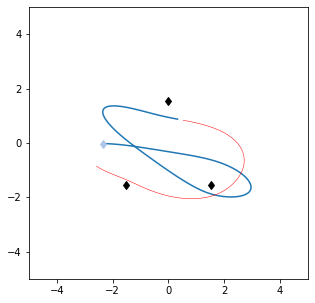

Charges are [-0.71567692 -0.8646266  -0.92353406]


In [9]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
print(f'Charges are {charges_train[test_idx]}')

In [10]:
simulation_train[test_idx].shape

(105, 2)

In [11]:
simulation_train[test_idx][:,0] #takes all rows from only first column index 0 is column 1, x coordinate in this case

array([-2.35600094, -2.23935459, -2.11182211, -1.97370126, -1.82538426,
       -1.66737686, -1.50031248, -1.32495593, -1.14219112, -0.95299228,
       -0.75838461, -0.55940449, -0.35706761, -0.15234612,  0.05384719,
        0.26066789,  0.46733718,  0.67311962,  0.87727384,  1.07897234,
        1.2771952 ,  1.47062289,  1.65758983,  1.83617909,  2.00447417,
        2.16084767,  2.30412527,  2.4335815 ,  2.54883941,  2.6497552 ,
        2.73632604,  2.80862711,  2.86677156,  2.91088619,  2.94109673,
        2.95751909,  2.96025402,  2.94938386,  2.92497033,  2.88705299,
        2.83564784,  2.7707461 ,  2.69231302,  2.60028698,  2.4945796 ,
        2.37507874,  2.24165931,  2.09421563,  1.93275629,  1.75769329,
        1.57073274,  1.37684121,  1.1838203 ,  0.99603552,  0.81354954,
        0.63524576,  0.46004177,  0.28708998,  0.11578052, -0.05427005,
       -0.22321272, -0.39094241, -0.55706923, -0.72090794, -0.88151199,
       -1.03776178, -1.18848575, -1.33257383, -1.46905342, -1.59

In [12]:
simulation_train[test_idx][:,1]  #takes all rows from only second column index 1 is second column, y coordinate value in this case

array([-0.02607488, -0.02797182, -0.03328763, -0.04213094, -0.05457876,
       -0.07065395, -0.09029678, -0.11333486, -0.13946063, -0.16822946,
       -0.19908933, -0.23144368, -0.26473571, -0.2985345 , -0.33260434,
       -0.36694675, -0.40181459, -0.4377043 , -0.47533215, -0.51559297,
       -0.55948708, -0.6079897 , -0.66184958, -0.7213631 , -0.78624717,
       -0.85570957, -0.92866756, -1.0039724 , -1.08055051, -1.15745976,
       -1.23389461, -1.30916931, -1.38269519, -1.45395886, -1.52250349,
       -1.58791331, -1.6498007 , -1.7077953 , -1.76153427, -1.81065322,
       -1.85477681, -1.8935085 , -1.92641817, -1.95302604, -1.97278036,
       -1.9850243 , -1.98894391, -1.98348143, -1.96718508, -1.93795699,
       -1.89280436, -1.82882368, -1.74730841, -1.65377896, -1.55262878,
       -1.44617269, -1.33563783, -1.22177944, -1.10517017, -0.98634523,
       -0.8658811 , -0.74443272, -0.62273176, -0.50154558, -0.38160915,
       -0.26355958, -0.14790349, -0.03502506,  0.07478173,  0.18

In [13]:
len(charges_train)
charges_train[1].shape

(3,)

# Task 3.1

## Data Handling and Preprocessing

In [14]:
import torch
from torch.utils.data import DataLoader
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset, random_split
import numpy as np
from PIL import Image
from torch.nn.utils.rnn import pad_sequence

device=torch.device("cuda" if torch.cuda.is_available()else "cpu")

class MyDataset(Dataset):
  def __init__(self,simulations,charges):

    #maximum length of each simulation performed is 110 seconds
    max_length=110 

    #pad the arrays with zeros so that all sequences have same length
    padded_sim=[]
    for i in range(len(simulations)):
      if len(simulations[i]) != max_length:
          x = np.pad(simulations[i],[(0,max_length-len(simulations[i])),(0,0)], 'constant',constant_values = 0) #padding zeros at the end of dimension 1 ie rows 
      else:
          x = simulations[i]
      padded_sim.append(x)

    data=np.array(padded_sim) #convert list into numpy array data = simulations of all length 110
    #shape of data
    (n_samples,length,dim)=data.shape
    #convert simulations to tensor structure
    self.data=torch.FloatTensor(data).view(n_samples,1,-1) #reshape so that 
    print("Dimensions of data",self.data.shape)
    #convert charges to numpy array first
    charges=np.array(charges)
    self.target=torch.FloatTensor(charges)
    print("Dimensions of label",self.target.shape)

  def __getitem__(self, index):
    X=self.data[index]
    Y=self.target[index]
    return X,Y

  def __len__(self):
    return len(self.data)

    


In [15]:

train_dataset=MyDataset(simulation_train,charges_train)
val_dataset = MyDataset(simulation_valid,charges_valid)
test_dataset=MyDataset(simulation_test,charges_test)
test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=10)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)


Dimensions of data torch.Size([800, 1, 220])
Dimensions of label torch.Size([800, 3])
Dimensions of data torch.Size([100, 1, 220])
Dimensions of label torch.Size([100, 3])
Dimensions of data torch.Size([100, 1, 220])
Dimensions of label torch.Size([100, 3])


In [16]:
#check how 3rd sample of train dataset looks like
X,Y=test_dataset[2]
print(X)
print(Y)

tensor([[ 2.3561, -0.1385,  2.2400, -0.1432,  2.1133, -0.1518,  1.9764, -0.1643,
          1.8296, -0.1809,  1.6734, -0.2017,  1.5086, -0.2269,  1.3358, -0.2562,
          1.1560, -0.2896,  0.9701, -0.3266,  0.7792, -0.3667,  0.5840, -0.4095,
          0.3855, -0.4544,  0.1842, -0.5009, -0.0191, -0.5488, -0.2242, -0.5981,
         -0.4307, -0.6488, -0.6382, -0.7016, -0.8466, -0.7571, -1.0554, -0.8164,
         -1.2639, -0.8811, -1.4706, -0.9532, -1.6726, -1.0344, -1.8650, -1.1252,
         -2.0435, -1.2232, -2.2055, -1.3249, -2.3508, -1.4271, -2.4798, -1.5280,
         -2.5931, -1.6260, -2.6913, -1.7203, -2.7752, -1.8102, -2.8451, -1.8954,
         -2.9016, -1.9753, -2.9450, -2.0497, -2.9756, -2.1184, -2.9937, -2.1811,
         -2.9996, -2.2375, -2.9933, -2.2875, -2.9752, -2.3309, -2.9452, -2.3674,
         -2.9037, -2.3967, -2.8505, -2.4187, -2.7859, -2.4330, -2.7098, -2.4393,
         -2.6224, -2.4373, -2.5236, -2.4265, -2.4135, -2.4065, -2.2921, -2.3767,
         -2.1595, -2.3363, -

In [17]:
input_dim = next(iter(train_loader))[0].shape[2]
input_dim

220

## Model Implementation

In [18]:
#3.1 task 
from torch import nn
class LSTM_a2(nn.Module):
  def __init__(self,input_dim,hidden_dim,output_dim,device):
    super(LSTM_a2,self).__init__()

    self.input_dim=input_dim
    self.hidden_dim=hidden_dim
    self.device=device

    self.rnn=nn.LSTMCell(input_dim,hidden_dim)
    self.fc1=nn.Linear(hidden_dim,hidden_dim)
    self.fc2=nn.Linear(hidden_dim,output_dim)

    self.criterion=nn.MSELoss()
    #self.optimizer=torch.optim.Adam(self.parameters())
  
  def forward(self,batch_input):

    #shape of input , batch_input: [batch_size, 1,seq_length]
    #generate random initial hidden and cell states
    hidden_0=torch.randn(batch_input.shape[0],self.hidden_dim).to(self.device)
    c_0=torch.randn(batch_input.shape[0],self.hidden_dim).to(self.device)
    for i in range(0,220,2):
             hidden_1,c_1 = self.rnn(batch_input[:,0,i:i+2],(hidden_0,c_0))
            

    
    h1=nn.ReLU()(self.fc1(hidden_1))
    out1=self.fc2(h1)
    
    return out1

  




## Model Training

In [19]:

def save_model_checkpoint(path, model, optimizer, val_loss, val_acc, train_acc, train_loss ):
    if path == None:
        return print("Kindly define a path")
    path = path
    
    save_dict = {"model_dict" : model.state_dict(), 
                 "optimizer_dict": optimizer.state_dict(),
                 "val_loss_dict": val_loss,
                 "val_acc_dict": val_acc,
                 "train_acc_dict": train_acc,
                 "train_loss_dict": train_loss}
    torch.save(save_dict, path)
    return print("Model Saved to ==> {}".format(path))

In [20]:
# training and validation after every epoch
def train(model, train_loader, val_loader, criterion,num_epochs, save_name):
    best_val_loss = float("Inf") 
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    cur_step = 0
    train_pred = []
    val_pred = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_train_acc = 0.0
  
        model.train()
        print("Starting epoch " + str(epoch+1))
        for train_data, targets in train_loader:
            
           
            # Forward
            input_tensor = train_data.to(device)
            outputs = model.forward(input_tensor)
            loss = criterion(outputs,targets.to(device))
            # loss = loss/60
                
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()   
            running_loss += loss
          

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print("Training Pass Completed")

        ########################################|Validation Set|#############################################
        val_running_loss = 0.0
        with torch.no_grad():
            model.eval()
            for val_data, val_targets in val_loader:
                input_tensor = val_data.to(device)
                outputs = model.forward(input_tensor)
                loss = criterion(outputs,val_targets.to(device))
                # loss = loss/60
                val_running_loss += loss

        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        
        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}' 
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss 
            save_model_checkpoint(save_name, model, optimizer, best_val_loss, 0, 0, avg_train_loss )
    
    print("Finished Training") 
    return train_losses, val_losses
     

In [21]:

from torch.nn import L1Loss

model=LSTM_a2(2,256,3,device='cpu')

#optimizer=torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
#optimizer=torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = torch.optim.Adam(model.parameters(), lr= 0.001, weight_decay = 0.01)

num_epochs = 150
save_name = f'LSTM_1.pt'
criterion = nn.MSELoss()
#criterion=L1Loss()

obtained_train_loss, obtained_val_loss = train(model, 
                                                      train_loader, val_loader, criterion, num_epochs, save_name)

Starting epoch 1
Training Pass Completed
Epoch [1/150],Train Loss: 0.1629, Valid Loss: 0.09744691
Model Saved to ==> LSTM_1.pt
Starting epoch 2
Training Pass Completed
Epoch [2/150],Train Loss: 0.0896, Valid Loss: 0.09296661
Model Saved to ==> LSTM_1.pt
Starting epoch 3
Training Pass Completed
Epoch [3/150],Train Loss: 0.0842, Valid Loss: 0.09512015
Starting epoch 4
Training Pass Completed
Epoch [4/150],Train Loss: 0.0843, Valid Loss: 0.08963707
Model Saved to ==> LSTM_1.pt
Starting epoch 5
Training Pass Completed
Epoch [5/150],Train Loss: 0.0849, Valid Loss: 0.08862054
Model Saved to ==> LSTM_1.pt
Starting epoch 6
Training Pass Completed
Epoch [6/150],Train Loss: 0.0834, Valid Loss: 0.09306136
Starting epoch 7
Training Pass Completed
Epoch [7/150],Train Loss: 0.0833, Valid Loss: 0.09331287
Starting epoch 8
Training Pass Completed
Epoch [8/150],Train Loss: 0.0844, Valid Loss: 0.09416815
Starting epoch 9
Training Pass Completed
Epoch [9/150],Train Loss: 0.0840, Valid Loss: 0.09164658
St

In [22]:
print(min([tensor.detach().item() for tensor in obtained_val_loss]))

0.08734273165464401


In [23]:
val_loss_adagrad=[0.10775696486234665, 0.09990982711315155, 0.09356175363063812, 0.09261330217123032, 0.09110166877508163, 0.09626977890729904, 0.09320446848869324, 0.09535153210163116, 0.0920148491859436, 0.096127450466156, 0.0983283594250679, 0.09121722728013992, 0.09322917461395264, 0.09332352876663208, 0.09810879826545715, 0.09423799812793732, 0.09266828000545502, 0.09509880095720291, 0.09212228655815125, 0.094944067299366, 0.09023258090019226, 0.0931842103600502, 0.09399161487817764, 0.09303907305002213, 0.09374510496854782, 0.0925590768456459, 0.0925554633140564, 0.09466703981161118, 0.08906292915344238, 0.0924035832285881, 0.09407301247119904, 0.09164590388536453, 0.09295303374528885, 0.08733920007944107, 0.09620130062103271, 0.0922817811369896, 0.09552191942930222, 0.09065622836351395, 0.09351206570863724, 0.09633152186870575, 0.09349539130926132, 0.090006522834301, 0.09232228249311447, 0.09217618405818939, 0.09430994838476181, 0.09510460495948792, 0.09720087051391602, 0.09396366029977798, 0.08832370489835739, 0.09244177490472794, 0.0933479368686676, 0.09335318952798843, 0.0905676856637001, 0.09265295416116714, 0.09386637061834335, 0.09579864144325256, 0.09089333564043045, 0.09009724110364914, 0.08936219662427902, 0.09318411350250244, 0.09202060848474503, 0.09120874106884003, 0.09186840802431107, 0.09208668768405914, 0.08917973935604095, 0.09026630222797394, 0.09194076806306839, 0.09493733197450638, 0.09563656151294708, 0.09190733730792999, 0.09238652139902115, 0.0902077853679657, 0.09229909628629684, 0.08977751433849335, 0.09441301971673965, 0.09370480477809906, 0.09389881044626236, 0.09271634370088577, 0.09004056453704834, 0.09366809576749802, 0.09300873428583145, 0.09405921399593353, 0.09198001772165298, 0.0923023372888565, 0.09339451789855957, 0.09404896944761276, 0.09403906762599945, 0.09024978429079056, 0.09204896539449692, 0.09343773126602173, 0.09405837953090668, 0.09104418754577637, 0.09499628096818924, 0.09016826003789902, 0.09426487982273102, 0.09013887494802475, 0.09215015172958374, 0.0932808518409729, 0.0920465737581253, 0.0917765200138092, 0.09194115549325943, 0.0938996747136116, 0.0885835736989975, 0.09126915782690048, 0.09277617931365967, 0.09333697706460953, 0.09050162881612778, 0.09099341928958893, 0.09443147480487823, 0.09495674073696136, 0.09256146848201752, 0.09050930291414261, 0.0913139283657074, 0.09256158024072647, 0.09558137506246567, 0.0926317498087883, 0.09308324009180069, 0.0892009288072586, 0.09329825639724731, 0.08898835629224777, 0.09080056846141815, 0.09171279519796371, 0.09230776131153107, 0.09062528610229492, 0.09183109551668167, 0.09362627565860748, 0.09339401870965958, 0.09265417605638504, 0.09053554385900497, 0.09331195801496506, 0.09056562185287476, 0.09242362529039383, 0.0904649868607521, 0.09264250844717026, 0.09379438310861588, 0.09344030916690826, 0.09234251827001572, 0.0922057256102562, 0.09025966376066208, 0.09066358953714371, 0.09241080284118652, 0.09366975724697113, 0.08974472433328629, 0.09368561208248138, 0.09476951509714127, 0.0916583389043808, 0.0926600843667984, 0.09181084483861923, 0.09187254309654236, 0.09340328723192215]

In [24]:
val_loss_adam=[0.12296508997678757, 0.09556609392166138, 0.1006212905049324, 0.10212159156799316, 0.09822243452072144, 0.09847055375576019, 0.09731344133615494, 0.09632331132888794, 0.0935005322098732, 0.09493404626846313, 0.09233900159597397, 0.09604939073324203, 0.09344117343425751, 0.095109723508358, 0.09695472568273544, 0.09572571516036987, 0.09370797872543335, 0.09437590092420578, 0.09653192013502121, 0.095401830971241, 0.09000592678785324, 0.09435334801673889, 0.09389906376600266, 0.09674026072025299, 0.09428450465202332, 0.09316908568143845, 0.0915304645895958, 0.09658324718475342, 0.0914929062128067, 0.09070684760808945, 0.0999055877327919, 0.10278231650590897, 0.09293412417173386, 0.09597516059875488, 0.09299665689468384, 0.09295130521059036, 0.09396441280841827, 0.09401188045740128, 0.09220462292432785, 0.09588828682899475, 0.09624627232551575, 0.094636470079422, 0.09386979043483734, 0.09139809757471085, 0.09461529552936554, 0.09445671737194061, 0.09360909461975098, 0.0912790521979332, 0.09293743222951889, 0.0934622585773468, 0.09521378576755524, 0.09276725351810455, 0.09251800924539566, 0.09393846988677979, 0.09392613172531128, 0.09225927293300629, 0.09252999722957611, 0.09185706824064255, 0.0933009684085846, 0.0904800221323967, 0.09330812096595764, 0.09358543902635574, 0.09154193103313446, 0.09177282452583313, 0.09451105445623398, 0.09463188797235489, 0.09268354624509811, 0.09424841403961182, 0.09198615700006485, 0.08967051655054092, 0.09174946695566177, 0.09271553158760071, 0.09360775351524353, 0.09529147297143936, 0.09440536797046661, 0.09333918243646622, 0.09167390316724777, 0.091200090944767, 0.09384336322546005, 0.09371115267276764, 0.09192340075969696, 0.0943499505519867, 0.09480199962854385, 0.08979517966508865, 0.09202273935079575, 0.09031543880701065, 0.09358120709657669, 0.0909731388092041, 0.08958359062671661, 0.09036674350500107, 0.09372510015964508, 0.09074749797582626, 0.09189340472221375, 0.09246257692575455, 0.09270744770765305, 0.0935666561126709, 0.09313010424375534, 0.09309736639261246, 0.08886104077100754, 0.09333416074514389, 0.09096422046422958, 0.09222117066383362, 0.0919971913099289, 0.0906357392668724, 0.09115485846996307, 0.09003614634275436, 0.09321502596139908, 0.09307845681905746, 0.09226669371128082, 0.09188651293516159, 0.0926167443394661, 0.09275801479816437, 0.09161069989204407, 0.09211697429418564, 0.09208118915557861, 0.09017246216535568, 0.09073369950056076, 0.09175865352153778, 0.09180852770805359, 0.09313041716814041, 0.09311217069625854, 0.09206037223339081, 0.09451041370630264, 0.09364200383424759, 0.09180519729852676, 0.09432439506053925, 0.0910857543349266, 0.09169841557741165, 0.09370984137058258, 0.09234414994716644, 0.09170742332935333, 0.09115937352180481, 0.09203428775072098, 0.09251650422811508, 0.09291784465312958, 0.09297361969947815, 0.0919882208108902, 0.09132539480924606, 0.09229638427495956, 0.09057865291833878, 0.09280334413051605, 0.09103507548570633, 0.09207046777009964, 0.09198334813117981, 0.09328224509954453, 0.09052105247974396, 0.09070400148630142, 0.09186679124832153, 0.09111606329679489, 0.0914120227098465]

In [25]:
val_loss_rms=[0.0988837257027626, 0.09208862483501434, 0.09344396740198135, 0.09711971879005432, 0.09507162868976593, 0.09286445379257202, 0.09192182868719101, 0.09472546726465225, 0.09334594011306763, 0.09392701834440231, 0.09608195722103119, 0.09006042778491974, 0.09208842366933823, 0.09570910036563873, 0.08931601792573929, 0.08947623521089554, 0.09273874759674072, 0.09475167840719223, 0.09329439699649811, 0.0933218002319336, 0.09115040302276611, 0.09498972445726395, 0.09067721664905548, 0.09050827473402023, 0.090626060962677, 0.09480041265487671, 0.09368706494569778, 0.0913509875535965, 0.08989205956459045, 0.09190718084573746, 0.09502244740724564, 0.09039454907178879, 0.0940360426902771, 0.0918930247426033, 0.09066776931285858, 0.09146369993686676, 0.09120883047580719, 0.09234746545553207, 0.09167943149805069, 0.09343191981315613, 0.09125420451164246, 0.0956616997718811, 0.09096821397542953, 0.09206687659025192, 0.09132635593414307, 0.09482698887586594, 0.09317934513092041, 0.09172386676073074, 0.0926685556769371, 0.09271682053804398, 0.09182586520910263, 0.09138220548629761, 0.09284266084432602, 0.09079664200544357, 0.09217057377099991, 0.09039860963821411, 0.09445807337760925, 0.09136983007192612, 0.09236463904380798, 0.09093628823757172, 0.09156893938779831, 0.09207524359226227, 0.09128594398498535, 0.09067298471927643, 0.09136123210191727, 0.09163456410169601, 0.09377925097942352, 0.09138384461402893, 0.08954472094774246, 0.08996136486530304, 0.09039847552776337, 0.08839161694049835, 0.08914825320243835, 0.0911293625831604, 0.08995255827903748, 0.09202560782432556, 0.092991404235363, 0.09019885212182999, 0.09109261631965637, 0.09299243241548538, 0.0916011780500412, 0.08998782187700272, 0.09188420325517654, 0.09172309190034866, 0.09188631922006607, 0.09333161264657974, 0.0929393395781517, 0.0902060866355896, 0.09128303825855255, 0.0904221162199974, 0.09135671705007553, 0.09181680530309677, 0.09367779642343521, 0.09348117560148239, 0.09058307111263275, 0.09262412041425705, 0.09262214601039886, 0.09108014404773712, 0.09412475675344467, 0.09338677674531937, 0.09075579047203064, 0.09086599946022034, 0.09076034277677536, 0.09198015183210373, 0.09035269916057587, 0.08855272084474564, 0.08943627029657364, 0.0923495963215828, 0.0919671356678009, 0.09063056111335754, 0.09169074892997742, 0.09205806255340576, 0.09204936772584915, 0.08958767354488373, 0.09224249422550201, 0.09166153520345688, 0.09152254462242126, 0.09100032597780228, 0.0922640860080719, 0.08998118340969086, 0.09160791337490082, 0.09152576327323914, 0.09307628124952316, 0.09271515905857086, 0.09202848374843597, 0.09077396988868713, 0.09122978895902634, 0.09229585528373718, 0.09120296686887741, 0.08976654708385468, 0.09237200021743774, 0.09047801792621613, 0.09079133719205856, 0.09186943620443344, 0.0923333391547203, 0.0911138504743576, 0.09191633015871048, 0.09024529904127121, 0.09212061762809753, 0.09262420982122421, 0.09090067446231842, 0.09361706674098969, 0.09164724498987198, 0.0913097932934761, 0.0913618803024292, 0.09080184251070023, 0.09136763960123062, 0.0892382338643074, 0.08979105949401855, 0.09145296365022659]

In [26]:
#btch size 32
val_loss_sgd=[0.09917441755533218, 0.0971212312579155, 0.09351310133934021, 0.09410262852907181, 0.09312011301517487, 0.09407547116279602, 0.0929272472858429, 0.0949389860033989, 0.0942491888999939, 0.0950004979968071, 0.09200269728899002, 0.09433328360319138, 0.09207777678966522, 0.09051712602376938, 0.09165138751268387, 0.09294359385967255, 0.09532535821199417, 0.08864817768335342, 0.08862218260765076, 0.09060294926166534, 0.09394847601652145, 0.08993735909461975, 0.09334416687488556, 0.09206844866275787, 0.09537860006093979, 0.09039304405450821, 0.09137063473463058, 0.09153836965560913, 0.0916115939617157, 0.08908955752849579, 0.0928502008318901, 0.09222683310508728, 0.09182010591030121, 0.09198211133480072, 0.09143495559692383, 0.09354401379823685, 0.08969493955373764, 0.09193620085716248, 0.09425333142280579, 0.09011512994766235, 0.09050146490335464, 0.09176962077617645, 0.09227767586708069, 0.09439055621623993, 0.09420838207006454, 0.09296485036611557, 0.09159029275178909, 0.09071015566587448, 0.09121961146593094, 0.09111123532056808, 0.08985384553670883, 0.09255733340978622, 0.0915253683924675, 0.09426827728748322, 0.08965608477592468, 0.09354428946971893, 0.092104472219944, 0.09280232340097427, 0.09177619218826294, 0.093030646443367, 0.09074875712394714, 0.0901191309094429, 0.09214714914560318, 0.09339792281389236, 0.09059453755617142, 0.09248299896717072, 0.09161704033613205, 0.09132129698991776, 0.09165271371603012, 0.09079200774431229, 0.09166766703128815, 0.09293315559625626, 0.0898880735039711, 0.09053746610879898, 0.09122821688652039, 0.09402376413345337, 0.09111043810844421, 0.0912482813000679, 0.09105625003576279, 0.09291192144155502, 0.09140040725469589, 0.09178835153579712, 0.08978153765201569, 0.09118733555078506, 0.09154986590147018, 0.09171783179044724, 0.09198739379644394, 0.09201928973197937, 0.09222589433193207, 0.0920478031039238, 0.09138604998588562, 0.09231704473495483, 0.09121058881282806, 0.09343033283948898, 0.0891614705324173, 0.0911724716424942, 0.0925518125295639, 0.0919656828045845, 0.09471137076616287, 0.09156688302755356, 0.09170594811439514, 0.09287400543689728, 0.09059429913759232, 0.09174574166536331, 0.09163731336593628, 0.0932878628373146, 0.08897019922733307, 0.09185825288295746, 0.09242774546146393, 0.09104681015014648, 0.09143905341625214, 0.0907173901796341, 0.090238057076931, 0.0915752425789833, 0.09253956377506256, 0.0908249244093895, 0.09092939645051956, 0.0916309505701065, 0.0920465737581253, 0.0915193259716034, 0.09022223204374313, 0.09215531498193741, 0.0923694595694542, 0.09039679914712906, 0.0928473100066185, 0.09175633639097214, 0.09163565188646317, 0.09073693305253983, 0.090929314494133, 0.09055275470018387, 0.09059929847717285, 0.09133899211883545, 0.09074568748474121, 0.09048456698656082, 0.09141881763935089, 0.09139322489500046, 0.09230083227157593, 0.09033191204071045, 0.09185725450515747, 0.08926243335008621, 0.09114501625299454, 0.09094735980033875, 0.09020201861858368, 0.09161797910928726, 0.09292725473642349, 0.09275822341442108, 0.09193868190050125, 0.09122804552316666, 0.09081518650054932, 0.09196557849645615]

In [27]:
val_loss_sgd_64=[0.12382839620113373, 0.1028372123837471, 0.0979565680027008, 0.09984959661960602, 0.0959034189581871, 0.09708070755004883, 0.09439248591661453, 0.09540762007236481, 0.09417067468166351, 0.09611763060092926, 0.09624640643596649, 0.09644931554794312, 0.09482872486114502, 0.09629341959953308, 0.09604882448911667, 0.09635424613952637, 0.09566663950681686, 0.09459982067346573, 0.09560892730951309, 0.09409362077713013, 0.09673285484313965, 0.09529753029346466, 0.09622733294963837, 0.09432077407836914, 0.09713148325681686, 0.09346701949834824, 0.09436565637588501, 0.09583740681409836, 0.09463179856538773, 0.09450303763151169, 0.09340304881334305, 0.0934324562549591, 0.09681031107902527, 0.09412511438131332, 0.09410850703716278, 0.09386345744132996, 0.09547457098960876, 0.09353050589561462, 0.0961889699101448, 0.09485161304473877, 0.09629405289888382, 0.09445935487747192, 0.09275062382221222, 0.09438042342662811, 0.09630433470010757, 0.09205414354801178, 0.09209941327571869, 0.09650308638811111, 0.09350895136594772, 0.09683491289615631, 0.09417055547237396, 0.09321599453687668, 0.09347814321517944, 0.09537126123905182, 0.09392647445201874, 0.09368206560611725, 0.09531737864017487, 0.09281644225120544, 0.09445759654045105, 0.09466579556465149, 0.09493619948625565, 0.09409664571285248, 0.09548535943031311, 0.09395471215248108, 0.09460532665252686, 0.09484829753637314, 0.0930221676826477, 0.09437549859285355, 0.09363704919815063, 0.09345126152038574, 0.09535086154937744, 0.09361264109611511, 0.09483674168586731, 0.09472835063934326, 0.0959150642156601, 0.09377069771289825, 0.09569565951824188, 0.09342021495103836, 0.09381523728370667, 0.09438661485910416, 0.09333959221839905, 0.09449061751365662, 0.09508773684501648, 0.09414967894554138, 0.09332932531833649, 0.09399956464767456, 0.09266923367977142, 0.09225267171859741, 0.09368294477462769, 0.09477666765451431, 0.09313571453094482, 0.09373486042022705, 0.09357090294361115, 0.09486151486635208, 0.0935693234205246, 0.09219765663146973, 0.0938301533460617, 0.0938015729188919, 0.09426974505186081, 0.09212101995944977, 0.09404444694519043, 0.09533065557479858, 0.09433965384960175, 0.09429355710744858, 0.09443823993206024, 0.0941493958234787, 0.09456571936607361, 0.09380780905485153, 0.09345260262489319, 0.09178061783313751, 0.09346844255924225, 0.0929201990365982, 0.09508082270622253, 0.0930936336517334, 0.09237536042928696, 0.09412530064582825, 0.09378639608621597, 0.09450338035821915, 0.09420166909694672, 0.09491346776485443, 0.09279663860797882, 0.09566393494606018, 0.09424150735139847, 0.09433360397815704, 0.09231531620025635, 0.09365534782409668, 0.09306035935878754, 0.0961783230304718, 0.09358932077884674, 0.09296183288097382, 0.09492890536785126, 0.09258535504341125, 0.09497178345918655, 0.09445056319236755, 0.09417688846588135, 0.0947822630405426, 0.09419289231300354, 0.09342566132545471, 0.0931592509150505, 0.09538472443819046, 0.09440581500530243, 0.09502175450325012, 0.09357576072216034, 0.09371230751276016, 0.09219770133495331, 0.09427250176668167, 0.09498538076877594, 0.09316517412662506, 0.09417396783828735, 0.09330317378044128]

In [28]:
val_loss_sgd_128=[0.24403636157512665, 0.11372974514961243, 0.10079863667488098, 0.10403566807508469, 0.09583748877048492, 0.09424053877592087, 0.09111171215772629, 0.09396224468946457, 0.09483135491609573, 0.09391868859529495, 0.09486792236566544, 0.09282085299491882, 0.09054027497768402, 0.0944986492395401, 0.09291540831327438, 0.09337787330150604, 0.0918654128909111, 0.09430444985628128, 0.09408290684223175, 0.093337282538414, 0.09410199522972107, 0.09243263304233551, 0.09521447867155075, 0.0931018590927124, 0.09401513636112213, 0.09490635246038437, 0.09105741232633591, 0.09286899864673615, 0.09525378048419952, 0.09417613595724106, 0.09287621080875397, 0.09227605164051056, 0.09529749304056168, 0.0962533950805664, 0.09306008368730545, 0.09323224425315857, 0.09170438349246979, 0.09181518852710724, 0.09337266534566879, 0.09450715780258179, 0.09331592172384262, 0.09212656319141388, 0.09227513521909714, 0.09319274127483368, 0.09359274804592133, 0.0929960161447525, 0.0911780521273613, 0.09215738624334335, 0.09276389330625534, 0.09454095363616943, 0.09273316711187363, 0.09257322549819946, 0.09065605700016022, 0.0915198028087616, 0.09455099701881409, 0.09100231528282166, 0.09423348307609558, 0.09294698387384415, 0.09453172236680984, 0.09330085664987564, 0.09334590286016464, 0.09343394637107849, 0.09495599567890167, 0.09359580278396606, 0.09362269192934036, 0.09175380319356918, 0.0918542668223381, 0.09187670052051544, 0.09355843812227249, 0.0930003747344017, 0.09239016473293304, 0.09360424429178238, 0.09273840487003326, 0.09317495673894882, 0.09325871616601944, 0.09264617413282394, 0.09282118827104568, 0.09355178475379944, 0.09308241307735443, 0.09296346455812454, 0.09430962055921555, 0.09255312383174896, 0.09370056539773941, 0.09421158581972122, 0.09397987276315689, 0.09131132811307907, 0.09186585992574692, 0.0917208269238472, 0.09290681779384613, 0.0938420370221138, 0.09198078513145447, 0.0944233313202858, 0.09095246344804764, 0.09206485748291016, 0.09370612353086472, 0.09198199957609177, 0.09343869239091873, 0.09198438376188278, 0.09098510444164276, 0.09443891793489456, 0.09267078340053558, 0.09212388843297958, 0.09274086356163025, 0.09363239258527756, 0.09224240481853485, 0.0920913890004158, 0.091832235455513, 0.094285748898983, 0.09090229868888855, 0.09237973392009735, 0.09211568534374237, 0.0943911150097847, 0.09317878633737564, 0.09159746766090393, 0.09352460503578186, 0.09392417222261429, 0.09358137845993042, 0.09351737797260284, 0.09187649935483932, 0.0936518982052803, 0.09201379865407944, 0.09474373608827591, 0.09351635724306107, 0.09247256815433502, 0.0947439968585968, 0.09166949987411499, 0.0931241363286972, 0.09320255368947983, 0.09285381436347961, 0.09321554005146027, 0.09192459285259247, 0.09456176310777664, 0.09316403418779373, 0.09241855144500732, 0.09326160699129105, 0.0927102118730545, 0.09243100136518478, 0.09235604107379913, 0.09176736325025558, 0.09164053946733475, 0.09084242582321167, 0.09365049749612808, 0.0926307961344719, 0.0921798050403595, 0.0928197130560875, 0.0934334322810173, 0.09295140951871872, 0.0927191972732544, 0.0920608788728714, 0.09247997403144836]

In [29]:
val_loss_sgd_4=[0.09487639367580414, 0.09486878663301468, 0.09217602759599686, 0.0927230715751648, 0.09364086389541626, 0.09276862442493439, 0.09182234108448029, 0.09089959412813187, 0.09490347653627396, 0.09338623285293579, 0.09407205879688263, 0.09290885180234909, 0.09195678681135178, 0.09494121372699738, 0.09276942163705826, 0.09291555732488632, 0.09199345856904984, 0.09140957146883011, 0.09145712107419968, 0.09361724555492401, 0.0917515829205513, 0.09385782480239868, 0.09173768013715744, 0.09199076890945435, 0.09144245088100433, 0.09201037138700485, 0.09243299812078476, 0.09333429485559464, 0.09389026463031769, 0.09231024980545044, 0.09242022782564163, 0.09311430156230927, 0.0930042564868927, 0.09128835052251816, 0.09064407646656036, 0.09190136194229126, 0.09142440557479858, 0.09272231161594391, 0.09340348094701767, 0.09212636202573776, 0.0911082774400711, 0.09240463376045227, 0.0920557975769043, 0.09300156682729721, 0.09272588789463043, 0.09049244970083237, 0.09175502508878708, 0.09222967177629471, 0.09107042104005814, 0.09308764338493347, 0.09218171238899231, 0.09295409917831421, 0.09189121425151825, 0.09271260350942612, 0.09138236194849014, 0.0921124815940857, 0.09130103886127472, 0.09223610162734985, 0.09176041930913925, 0.09192895889282227, 0.09041033685207367, 0.09166502207517624, 0.092386893928051, 0.09276697039604187, 0.0920943096280098, 0.09066309779882431, 0.0922507494688034, 0.09221241623163223, 0.0921236127614975, 0.0923033207654953, 0.09240270406007767, 0.09176011383533478, 0.09107377380132675, 0.09183496236801147, 0.09262187778949738, 0.09198835492134094, 0.09256978332996368, 0.09231677651405334, 0.09090600162744522, 0.09189394861459732, 0.09209686517715454, 0.09218940138816833, 0.09123935550451279, 0.09218110144138336, 0.09233912825584412, 0.09275136888027191, 0.09037311375141144, 0.09068377315998077, 0.09173788875341415, 0.09241031855344772, 0.09231418371200562, 0.09290910512208939, 0.09159865975379944, 0.09114180505275726, 0.09113604575395584, 0.09136325865983963, 0.09099559485912323, 0.09123355895280838, 0.09123290330171585, 0.09178833663463593, 0.09162259101867676, 0.09254509210586548, 0.09228456765413284, 0.09195282310247421, 0.0909862145781517, 0.09216784685850143, 0.09087434411048889, 0.09115119278430939, 0.0914512574672699, 0.09288539737462997, 0.09098376333713531, 0.09191813319921494, 0.09035231918096542, 0.09183423221111298, 0.09084878116846085, 0.09162862598896027, 0.09266430884599686, 0.09182838350534439, 0.09128904342651367, 0.09179267287254333, 0.0917850136756897, 0.09191185981035233, 0.09106289595365524, 0.09272745996713638, 0.09134524315595627, 0.0913480594754219, 0.09140634536743164, 0.09125320613384247, 0.09263695776462555, 0.09229391068220139, 0.09117908775806427, 0.09145000576972961, 0.09162741899490356, 0.09171608090400696, 0.090622179210186, 0.09210485219955444, 0.09240173548460007, 0.09138835221529007, 0.09216665476560593, 0.09216026216745377, 0.09250415116548538, 0.09189941734075546, 0.09137456864118576, 0.09183608740568161, 0.09231864660978317, 0.09165048599243164, 0.09239237755537033, 0.09195970743894577, 0.09127096831798553, 0.09152234345674515]

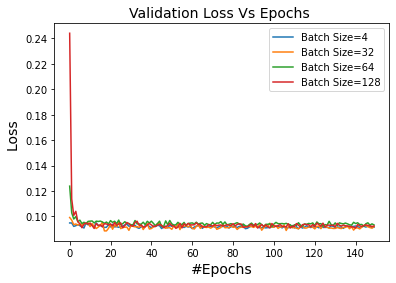

In [30]:
#plot validation loss for sgd optimizers for diff batch size

plt.plot(range(0,num_epochs),val_loss_sgd_4, label = "Batch Size=4")
plt.plot(range(0,num_epochs),val_loss_sgd, label = "Batch Size=32")
plt.plot(range(0,num_epochs),val_loss_sgd_64, label = "Batch Size=64")
plt.plot(range(0,num_epochs),val_loss_sgd_128, label = "Batch Size=128")

plt.title('Validation Loss Vs Epochs ', fontsize=14)
plt.xlabel('#Epochs', fontsize=14)
plt.ylabel('Loss ', fontsize=14)

plt.legend()
plt.show()

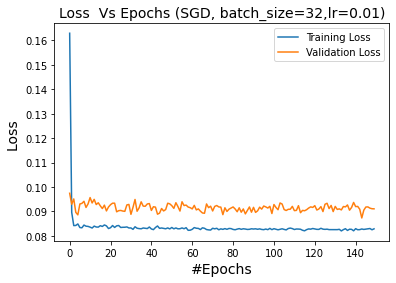

In [31]:
#Plotting training loss and validation loss curve

converted_train_loss_mse = [tensor.detach().item() for tensor in obtained_train_loss]
converted_val_loss_mse = [tensor.detach().item() for tensor in obtained_val_loss]

plt.plot(range(0,num_epochs),converted_train_loss_mse, label = "Training Loss")
plt.plot(range(0,num_epochs),converted_val_loss_mse, label = "Validation Loss")
plt.title('Loss  Vs Epochs (SGD, batch_size=32,lr=0.01)', fontsize=14)
plt.xlabel('#Epochs', fontsize=14)
plt.ylabel('Loss ', fontsize=14)

plt.legend()
plt.show()


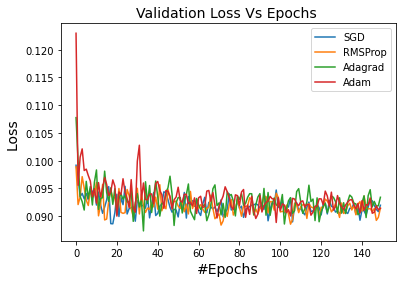

In [32]:
#plot validation loss for optimizers against each other with batch size=32 and default LR settings


plt.plot(range(0,num_epochs),val_loss_sgd, label = "SGD")
plt.plot(range(0,num_epochs),val_loss_rms, label = "RMSProp")
plt.plot(range(0,num_epochs),val_loss_adagrad, label = "Adagrad")
plt.plot(range(0,num_epochs),val_loss_adam, label = "Adam")
plt.title('Validation Loss Vs Epochs ', fontsize=14)
plt.xlabel('#Epochs', fontsize=14)
plt.ylabel('Loss ', fontsize=14)

plt.legend()
plt.show()


In [33]:
print(converted_val_loss_mse)

[0.09744691103696823, 0.09296660870313644, 0.0951201543211937, 0.08963707089424133, 0.08862054347991943, 0.09306135773658752, 0.09331286698579788, 0.09416814893484116, 0.09164658188819885, 0.09308996051549911, 0.09568684548139572, 0.09347834438085556, 0.09495221078395844, 0.09283201396465302, 0.09355708211660385, 0.09230145066976547, 0.09119419008493423, 0.09258939325809479, 0.09022631496191025, 0.09181191027164459, 0.09277718514204025, 0.09337940067052841, 0.09338738769292831, 0.08986477553844452, 0.0903284028172493, 0.09042554348707199, 0.09016885608434677, 0.09005283564329147, 0.09268655627965927, 0.09287575632333755, 0.08882833272218704, 0.09167469292879105, 0.09490795433521271, 0.09009499847888947, 0.09149238467216492, 0.09394607692956924, 0.09219004213809967, 0.09212484955787659, 0.09306499361991882, 0.09323500096797943, 0.09041973203420639, 0.09193418174982071, 0.09177801012992859, 0.08888483792543411, 0.08932394534349442, 0.09121211618185043, 0.09021640568971634, 0.090783059597

In [34]:
print(f"Best Val loss (LSTM_MSE): {min(converted_val_loss_mse)}")
print(f"Worst Val loss (LSTM_MSE): {max(converted_val_loss_mse)}")

Best Val loss (LSTM_MSE): 0.08734273165464401
Worst Val loss (LSTM_MSE): 0.09744691103696823


## Evaluation

In [35]:
#todo
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 7.2 MB/s 


In [36]:

#evaluate on the test set and calculate average test loss 
from sklearn.metrics import mean_squared_error
from torchmetrics import R2Score 
r2score = R2Score().to(device)
criterion = nn.L1Loss()
def evaluate(model, test_loader,device='cpu'):
    test_running_loss = 0.0
    count=0.0
    r2_score=0.0
    preds = []
    actual = []
    test_input = []
    losses=[]
    with torch.no_grad():
        model.eval()
        for test_data, test_label in test_loader:
            input_tensor = test_data.to(device)
            test_input.append(input_tensor)
            outputs = model.forward(input_tensor)
            preds.append(outputs)
            actual.append(test_label)
            loss = criterion(outputs,test_label.to(device))
            losses.append(loss)
            test_running_loss += loss
            #score = r2score(outputs, test_label)
            #r2_score += score
            count+=1
           
            print(f"MSE Loss after {count} iteration :", test_running_loss/count)



        print(test_running_loss)
        avg_test_loss = test_running_loss / len(test_loader)
        avg_r2_score = r2_score / len(test_loader)
        print("Average MSE Test Loss: {:4f}".format(avg_test_loss))
        #print("Average R2 score: {:4f}".format(avg_r2_score))
        return preds, actual, test_input,losses



In [37]:
preds,actual,input,losses= evaluate(model,test_loader)

MSE Loss after 1.0 iteration : tensor(0.2495)
MSE Loss after 2.0 iteration : tensor(0.2674)
MSE Loss after 3.0 iteration : tensor(0.2438)
MSE Loss after 4.0 iteration : tensor(0.2396)
MSE Loss after 5.0 iteration : tensor(0.2402)
MSE Loss after 6.0 iteration : tensor(0.2463)
MSE Loss after 7.0 iteration : tensor(0.2527)
MSE Loss after 8.0 iteration : tensor(0.2482)
MSE Loss after 9.0 iteration : tensor(0.2467)
MSE Loss after 10.0 iteration : tensor(0.2513)
tensor(2.5132)
Average MSE Test Loss: 0.251323


In [38]:
best_batch = np.argmin(losses)
worst_batch = np.argmax(losses)

print(f"The batch number in the test set with the best test loss is {best_batch}")
print(f"The batch in the set  with the worst test loss is {worst_batch}")

The batch number in the test set with the best test loss is 2
The batch in the set  with the worst test loss is 9


In [39]:
def input_tensor(inp_arr, batch_size, sequence_len, dim):
  input_array = []
  for i in inp_arr:
    input= i.reshape(batch_size, sequence_len, dim)
    input_array.append(input)
  return input_array

input_plot = input_tensor(input, 10,110,2)


Plot for simulations in best batch  2 & corresponding batch number 0



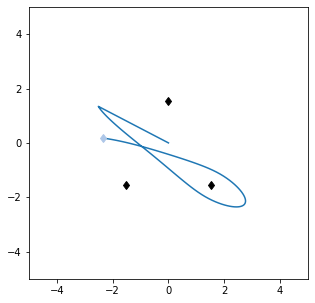

Predicted charges : tensor([-0.4887, -0.4781, -0.5185])
Actual charges : tensor([-0.5288, -0.4237, -0.4963])

Plot for simulations in best batch  2 & corresponding batch number 1



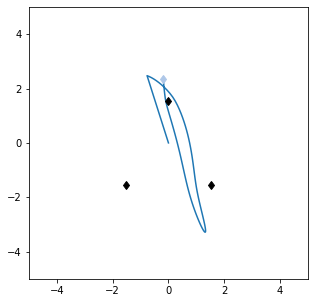

Predicted charges : tensor([-0.4437, -0.5040, -0.5208])
Actual charges : tensor([-0.5122, -0.5047, -0.5907])

Plot for simulations in best batch  2 & corresponding batch number 2



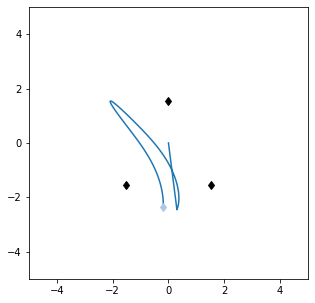

Predicted charges : tensor([-0.4766, -0.5019, -0.5381])
Actual charges : tensor([-0.8616, -0.1052, -0.4603])

Plot for simulations in best batch  2 & corresponding batch number 3



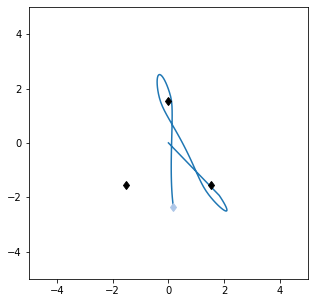

Predicted charges : tensor([-0.4838, -0.5184, -0.5216])
Actual charges : tensor([-0.5768, -0.7467, -0.7766])

Plot for simulations in best batch  2 & corresponding batch number 4



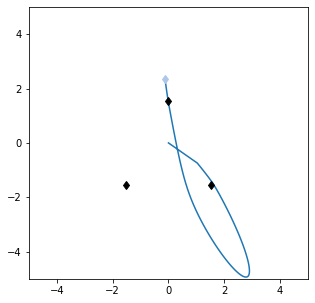

Predicted charges : tensor([-0.4819, -0.4409, -0.5012])
Actual charges : tensor([-0.3213, -0.7681, -0.1656])

Plot for simulations in best batch  2 & corresponding batch number 5



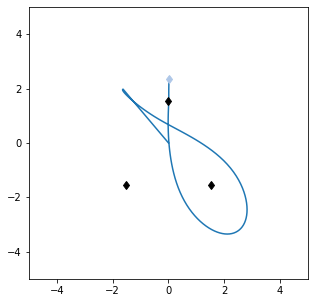

Predicted charges : tensor([-0.5041, -0.4834, -0.5195])
Actual charges : tensor([-0.1601, -0.9131, -0.5271])

Plot for simulations in best batch  2 & corresponding batch number 6



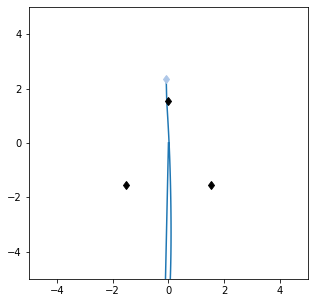

Predicted charges : tensor([-0.4797, -0.4995, -0.5479])
Actual charges : tensor([-0.2647, -0.2182, -0.0796])

Plot for simulations in best batch  2 & corresponding batch number 7



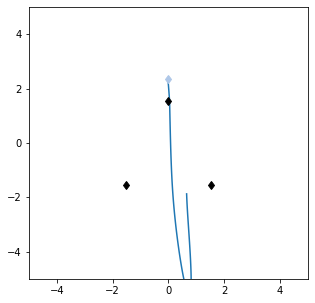

Predicted charges : tensor([-0.5010, -0.5144, -0.5649])
Actual charges : tensor([-0.3729, -0.4702, -0.1329])

Plot for simulations in best batch  2 & corresponding batch number 8



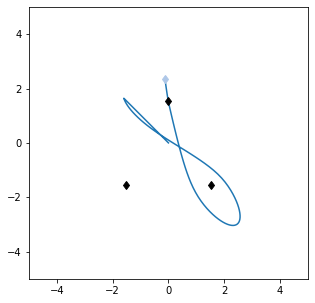

Predicted charges : tensor([-0.4537, -0.4781, -0.5224])
Actual charges : tensor([-0.2834, -0.9244, -0.6925])


In [40]:
#Plot the best cases

for batch_idx in range(9):
    print(f'\nPlot for simulations in best batch  {best_batch} & corresponding batch number {batch_idx}\n')
    plot_example(input_plot[best_batch][batch_idx])
    print(f'Predicted charges : {preds[best_batch][batch_idx]}')
    print(f'Actual charges : {actual[best_batch][batch_idx]}')
   


Plot for simulations in worst batch  2 & corresponding batch number 0



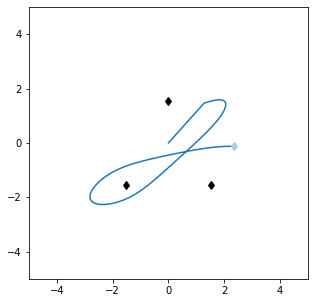

Predicted charges : tensor([-0.4712, -0.4540, -0.5251])
Actual charges : tensor([-0.8942, -0.7843, -0.8215])

Plot for simulations in worst batch  2 & corresponding batch number 1



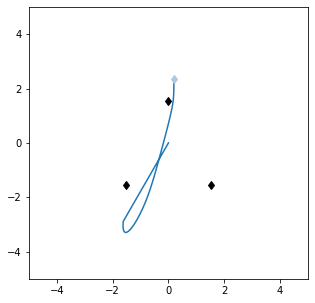

Predicted charges : tensor([-0.4790, -0.4961, -0.5053])
Actual charges : tensor([-0.1228, -0.0967, -0.2784])

Plot for simulations in worst batch  2 & corresponding batch number 2



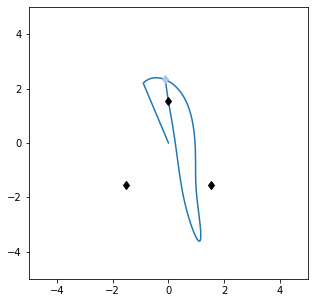

Predicted charges : tensor([-0.4784, -0.5211, -0.5309])
Actual charges : tensor([-0.7859, -0.9122, -0.7441])

Plot for simulations in worst batch  2 & corresponding batch number 3



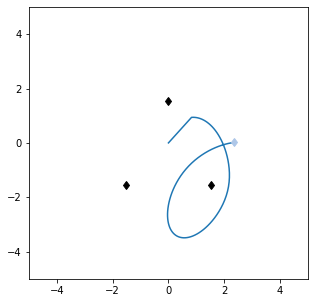

Predicted charges : tensor([-0.4683, -0.5070, -0.5227])
Actual charges : tensor([-0.0629, -0.9295, -0.1001])

Plot for simulations in worst batch  2 & corresponding batch number 4



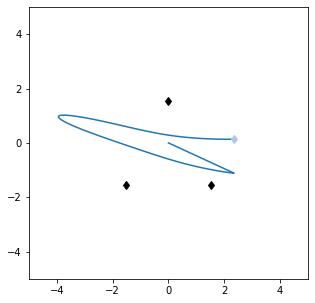

Predicted charges : tensor([-0.5025, -0.4828, -0.5371])
Actual charges : tensor([-0.6840, -0.0979, -0.9204])

Plot for simulations in worst batch  2 & corresponding batch number 5



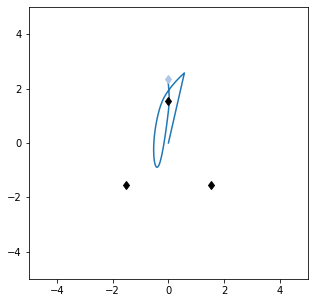

Predicted charges : tensor([-0.4600, -0.4924, -0.5289])
Actual charges : tensor([-0.1111, -0.0509, -0.6288])

Plot for simulations in worst batch  2 & corresponding batch number 6



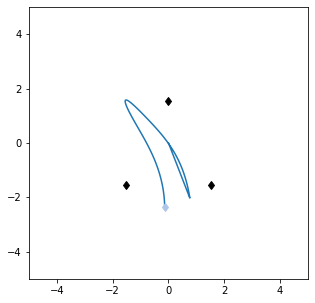

Predicted charges : tensor([-0.5145, -0.4983, -0.5609])
Actual charges : tensor([-0.7054, -0.2375, -0.3324])

Plot for simulations in worst batch  2 & corresponding batch number 7



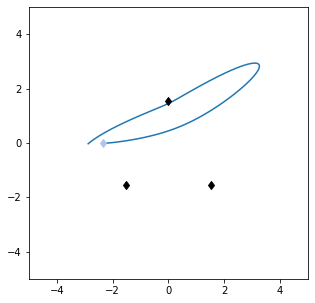

Predicted charges : tensor([-0.4964, -0.4908, -0.5113])
Actual charges : tensor([-0.0525, -0.3105, -0.8409])

Plot for simulations in worst batch  2 & corresponding batch number 8



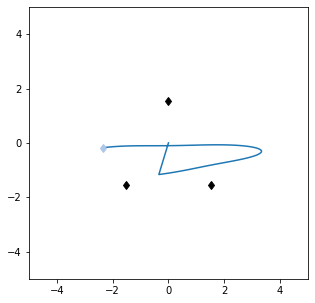

Predicted charges : tensor([-0.4620, -0.5012, -0.5289])
Actual charges : tensor([-0.3014, -0.2227, -0.3813])


In [41]:
#plot the worst cases

for batch_idx in range(9):
    print(f'\nPlot for simulations in worst batch  {best_batch} & corresponding batch number {batch_idx}\n')
    plot_example(input_plot[worst_batch][batch_idx])
    print(f'Predicted charges : {preds[worst_batch][batch_idx]}')
    print(f'Actual charges : {actual[worst_batch][batch_idx]}')
   

# Task 3.2

## Data Handling and Preprocessing

In [42]:
simulation_test[0][-1,1]#[-2.44181784e+00,  1.23685294e+00]

1.236852943008018

In [43]:
simulation_train[0][-1][1]

0.2843197322328459

In [44]:
#todo
#Task 3.2
import torch
from torch.utils.data import DataLoader
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset, random_split
import numpy as np

from torch.nn.utils.rnn import pad_sequence

device=torch.device("cuda" if torch.cuda.is_available()else "cpu")

class Dataset_Two(Dataset):
    def __init__(self, simulations,continued_simulations):

        #maximum length of each simulation performed is 110 seconds
        max_length=110 
        padded_sim = []

        for i in range(len(simulations)):
          if len(simulations[i]) != max_length:
            #  x = np.pad(simulations[i],[(0,max_length-len(simulations[i])),(0,0)], 'constant',constant_values =(simulations[i][-1][0],simulations[i][-1][1]))
            x = np.pad(simulations[i],[(0,max_length-len(simulations[i])),(0,0)], 'edge')
             #x = np.pad(simulations[i],[(0,max_length-len(simulations[i])),(0,0)], 'constant',constant_values =0 ) #padding zeros at the end of dimension 1 ie rows 
          else:
              x = simulations[i]
          padded_sim.append(x)
        #print("Padded Simulations",padded_sim[1])

        # Create data and target tensors
        data = np.array(padded_sim)
        (samples,length,dim) = data.shape
        self.data = torch.FloatTensor(data).view(samples,1,-1) # reshape so that they are of format (Samples,Channels,Sequence length)
        print("Length of input data ",len(self.data))
        print(" Shape of input data",self.data.shape)
        
        
       

        padded_len_target = 60#len(max(continued_simulations, key = len))
        padded_target_array = []
        for j in range(len(continued_simulations)):
            diff_targ = padded_len_target - continued_simulations[j].shape[0]
            padded_target_array.append(np.pad(continued_simulations[j], [(0, diff_targ), (0,0)], 'edge'))
        targets = np.array(padded_target_array)
        #print(targets[0])
        (tar_samples, tar_length, tar_dim) = targets.shape
        self.targets = torch.FloatTensor(targets).view(tar_samples,1,-1)
        print("Length of targets",len(self.targets))
        print("Shape of Target",self.targets.shape)
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        

        return x, y
    
    def __len__(self):
        return len(self.data)

In [45]:

train_dataset_2 = Dataset_Two(simulation_train_task32,simulation_continued_train)
train_loader_2 = torch.utils.data.DataLoader(train_dataset_2, batch_size=64)

valid_dataset_2 = Dataset_Two(simulation_valid,simulation_continued_valid)
valid_loader_2 = torch.utils.data.DataLoader(valid_dataset_2, batch_size=64)

test_dataset_2 = Dataset_Two(simulation_test,simulation_continued_test)
test_loader_2 = torch.utils.data.DataLoader(test_dataset_2, batch_size=10)

Length of input data  150
 Shape of input data torch.Size([150, 1, 220])
Length of targets 150
Shape of Target torch.Size([150, 1, 120])
Length of input data  100
 Shape of input data torch.Size([100, 1, 220])
Length of targets 100
Shape of Target torch.Size([100, 1, 120])
Length of input data  100
 Shape of input data torch.Size([100, 1, 220])
Length of targets 100
Shape of Target torch.Size([100, 1, 120])


## Model Implementation

In [46]:
#todo
#qs. Using the positions of positively charged particle p1 during a simulation up to t = 10±1, continue its trajectory for an additional 4 ± 2 seconds.
#LSTM Model
#model has two input dimensions(x,y) coordinates=2 and output dimension will be 120(shape of targets)
#output is a sequence of 120

from torch import nn
class LSTM_3_2(nn.Module):

    def __init__(self, input_dim,hidden_dim,output_dim,device):
        super(LSTM_3_2, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.device = device
        
        # RNN units using LSTM Cells
        self.rnn1 = nn.LSTMCell(input_dim, hidden_dim)
        self.rnn2 = nn.LSTMCell(hidden_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, batch_input ):
        
        # input shapes:
        # batch_input: [batch_size, 1,seq_length]
        # initial hidden and cell states
        hidden_0 = torch.randn(batch_input.shape[0], self.hidden_dim).to(self.device) 
        c_0=torch.randn(batch_input.shape[0],self.hidden_dim).to(self.device)
        
        # Feed packed input sequence to lstm 
        for i in range(0,220,2):
            hidden_1,c_1 = self.rnn1(batch_input[:,0,i:i+2],(hidden_0,c_0)) # Pass the i-th compressed sequence step
      
        #[batch_size, hidden_dim]
        #hidden_dim = [10, 256]
        hidden_vectors = []
        output_vectors = []
        
        hidden2 = torch.randn(batch_input.shape[0], self.hidden_dim).to(self.device)
        #each sequence generated untill
        for j in range(0,60):
            hidden2,c_2 = self.rnn2(hidden2,( hidden_1,c_1))
            hidden_vectors.append(hidden2)
            #vector= [10, 256]
            #batch =[1,256]
        
        
        for op in range(len(hidden_vectors)):
            h1 = nn.ReLU()(self.fc1(hidden_vectors[op]))
            h2 = self.fc2(h1) # [10,256] and [256,2]
           
            

            output_vectors.append(h2)
            
        outputs = torch.stack(output_vectors, dim=1)
        
        final_output = []
        for tens in range(len(outputs)):
            t = outputs[tens].view(1,-1) 
            final_output.append(t)
        
        model_output = torch.stack(final_output)
            
        return model_output

In [47]:
# GRUimplementation of same LST structure
#we need our model to have input dim = 2 and output_dim = 120 (we need a sequence in the output) 

class GRURegressor32(nn.Module):

    def __init__(self, input_dim,hidden_dim,output_dim,device):
        super(GRURegressor32, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.device = device
        self.rnn1 = nn.GRUCell(input_dim, hidden_dim)
        self.rnn2 = nn.GRUCell(hidden_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, batch_input ):
        
        # input shapes:
        # batch_input: [batch_size, 1,length of sequence]
        # Generate initial hidden and cell states
        hidden = torch.randn(batch_input.shape[0], self.hidden_dim).to(self.device) 
        
        # Feed packed input sequence to lstm 
        for i in range(0,220,2):
            hidden = self.rnn1(batch_input[:,0,i:i+2],hidden) # Pass the i-th compressed sequence step
        # feed output to MLP, apply ReLU nonlinearity
        # shape [batch_size, hidden_dim]
        #hidden_dim = [10, 256]
        
        
        #hidden vector at time = t
        hidden_vectors = []
        output_vectors = []
        
        hidden2 = torch.randn(batch_input.shape[0], self.hidden_dim).to(self.device)
        for j in range(0,60):
            hidden2 = self.rnn2(hidden, hidden2)
            hidden_vectors.append(hidden2)
        
        
        for op in range(len(hidden_vectors)):
            h1 = nn.ReLU()(self.fc1(hidden_vectors[op]))
            h2 = self.fc2(h1) #fully connected layer operation[10,256] and [256,2]
            #h2 has a dimension (10, 2)
            #h2 batch =1 has the shape (1,2) and we have 60 time steps.
            

            output_vectors.append(h2)
            
        outputs = torch.stack(output_vectors, dim=1)
        
        final_output = []
        for output in range(len(outputs)):
            t = outputs[output].view(1,-1)
            final_output.append(t)
        
        model_output = torch.stack(final_output)
            
        return model_output

## Model Training

In [48]:
#todo

def save_model_checkpoint(path, model, optimizer, val_loss, val_acc, train_acc, train_loss ):
    if path == None:
        return print("Kindly define a path")
    path = path
    
    save_dict = {"model_dict" : model.state_dict(), 
                 "optimizer_dict": optimizer.state_dict(),
                 "val_loss_dict": val_loss,
                 "val_acc_dict": val_acc,
                 "train_acc_dict": train_acc,
                 "train_loss_dict": train_loss}
    torch.save(save_dict, path)
    return print("Model Saved to ==> {}".format(path))

In [49]:
# Check training and validation after each epoch

def train(model, train_loader, val_loader, criterion,num_epochs, save_name):
    best_val_loss = float("Inf") 
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    cur_step = 0
    train_pred = []
    val_pred = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_train_acc = 0.0
  
        model.train()
        print("Epoch :  " + str(epoch+1))
        for train_data, targets in train_loader:
            
           
            # Forward propagation
            input_tensor = train_data.to(device)
            outputs = model.forward(input_tensor)
            loss = criterion(outputs,targets.to(device))

                
            # Backward propagation and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()   
            running_loss += loss
          

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print("Train Pass Completed")

       ##|Validation Set|##

        val_running_loss = 0.0
        with torch.no_grad():
            model.eval()
            for val_data, val_targets in val_loader:
                input_tensor = val_data.to(device)
                outputs = model.forward(input_tensor)
                loss = criterion(outputs,val_targets.to(device))
               
                val_running_loss += loss

        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        
        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}' 
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss 
            save_model_checkpoint(save_name, model, optimizer, best_val_loss, 0, 0, avg_train_loss )
    
    print("Finished Training") 
    return train_losses, val_losses
     

In [50]:

# #device = 'cuda:0'
# LSTM_3_2 = LSTM_3_2(input_dim=2,hidden_dim=256,output_dim=2,device='cpu')
# optimizer = torch.optim.SGD(LSTM_3_2.parameters(), lr=0.001, momentum=0.9)
# #optimizer = torch.optim.Adam(LSTM_3_2.parameters(), lr= 1e-4)
# num_epochs = 350
# save_name = f'LSTM_300.pt'
# criterion = nn.MSELoss()
# obtained_train_loss_2, obtained_val_loss_2 = train(LSTM_3_2,
#                                                       train_loader_2, 
#                                                       valid_loader_2, criterion, num_epochs, save_name)


In [51]:
#Training on similar GRU Network with similar hyperparameters

GRURegressor32=GRURegressor32(input_dim=2,hidden_dim=256,output_dim=2,device='cpu')
optimizer = torch.optim.SGD(GRURegressor32.parameters(), lr=0.01, momentum=0.9)
#optimizer = torch.optim.Adam(GRU_reg32.parameters(), lr= 1e-4)
num_epochs = 350
save_name = f'gru_300.pt'
criterion = nn.MSELoss()

obtained_train_loss_3, obtained_val_loss_3 = train(GRURegressor32, 
                                                      train_loader_2, 
                                                      valid_loader_2, criterion, num_epochs, save_name)

Epoch :  1
Train Pass Completed
Epoch [1/350],Train Loss: 3.1353, Valid Loss: 3.39702415
Model Saved to ==> gru_300.pt
Epoch :  2
Train Pass Completed
Epoch [2/350],Train Loss: 3.0897, Valid Loss: 3.35750961
Model Saved to ==> gru_300.pt
Epoch :  3
Train Pass Completed
Epoch [3/350],Train Loss: 3.0227, Valid Loss: 3.31465292
Model Saved to ==> gru_300.pt
Epoch :  4
Train Pass Completed
Epoch [4/350],Train Loss: 2.9524, Valid Loss: 3.27725840
Model Saved to ==> gru_300.pt
Epoch :  5
Train Pass Completed
Epoch [5/350],Train Loss: 2.8914, Valid Loss: 3.24907303
Model Saved to ==> gru_300.pt
Epoch :  6
Train Pass Completed
Epoch [6/350],Train Loss: 2.8374, Valid Loss: 3.21593189
Model Saved to ==> gru_300.pt
Epoch :  7
Train Pass Completed
Epoch [7/350],Train Loss: 2.7802, Valid Loss: 3.17448807
Model Saved to ==> gru_300.pt
Epoch :  8
Train Pass Completed
Epoch [8/350],Train Loss: 2.7309, Valid Loss: 3.13343143
Model Saved to ==> gru_300.pt
Epoch :  9
Train Pass Completed
Epoch [9/350],Tr

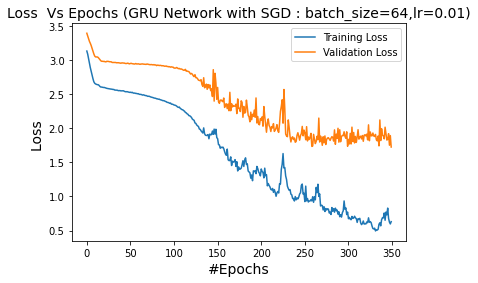

In [52]:
converted_train_loss_mse = [tensor.detach().item() for tensor in obtained_train_loss_3]
converted_val_loss_mse = [tensor.detach().item() for tensor in obtained_val_loss_3]

plt.plot(range(0,num_epochs),converted_train_loss_mse, label = "Training Loss")
plt.plot(range(0,num_epochs),converted_val_loss_mse, label = "Validation Loss")
plt.title('Loss  Vs Epochs (GRU Network with SGD : batch_size=64,lr=0.01)', fontsize=14)
plt.xlabel('#Epochs', fontsize=14)
plt.ylabel('Loss ', fontsize=14)

plt.legend()
plt.show()


In [53]:
print(f"Best Val loss (GRU): {min(obtained_val_loss)}")
print(f"Worst Val loss (GRU: {max(obtained_val_loss)}")

Best Val loss (GRU): 0.08734273165464401
Worst Val loss (GRU: 0.09744691103696823


## Evaluation

In [54]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [55]:
#todo
#task 3.2 evaluation on test data

#evaluate on the test set and calculate average test loss 
from sklearn.metrics import mean_squared_error
from torchmetrics import R2Score 
r2score = R2Score().to(device)
def evaluate(model, test_loader,device='cpu'):
    test_running_loss = 0.0
    count=0.0
    r2_score=0.0
    preds = []
    actual = []
    test_input = []
    with torch.no_grad():
        model.eval()
        for test_data, test_label in test_loader:
            input_tensor = test_data.to(device)
            test_input.append(input_tensor)
            outputs = model.forward(input_tensor)
            preds.append(outputs)
            actual.append(test_label)
            loss = criterion(outputs,test_label.to(device))
            test_running_loss += loss
            #score = r2score(outputs, test_label)
            #r2_score += score
            count+=1
            
            print(f"MSE Loss after {count} iteration :", test_running_loss/count)



        
        avg_test_loss = test_running_loss / len(test_loader)
        avg_r2_score = r2_score / len(test_loader)
        print("Average MSE Test Loss: {:4f}".format(avg_test_loss))
        #print("Average R2 score: {:4f}".format(avg_r2_score))
        return preds, actual, test_input



In [56]:
from sklearn.metrics import mean_squared_error
from torchmetrics import R2Score 
r2score = R2Score().to(device)
criterion = nn.MSELoss()
def evaluate(model, test_loader,device='cpu'):
    test_running_loss = 0.0
    count=0.0
    r2_score=0.0
    preds = []
    actual = []
    test_input = []
    losses=[]
    with torch.no_grad():
        model.eval()
        for test_data, test_label in test_loader:
            input_tensor = test_data.to(device)
            test_input.append(input_tensor)
            outputs = model.forward(input_tensor)
            preds.append(outputs)
            actual.append(test_label)
            loss = criterion(outputs,test_label.to(device))
            
            losses.append(loss)
            test_running_loss += loss
            #score = r2score(outputs, test_label)
            #r2_score += score
            #count+=1
           
            #print(f"RMSE Loss after {count} iteration :", test_running_loss/count)



        print([tensor.detach().item() for tensor in losses])
        avg_test_loss = test_running_loss / len(test_loader)
        avg_r2_score = r2_score / len(test_loader)
        print("Average MSE Test Loss: {:4f}".format(avg_test_loss))
        #print("Average R2 score: {:4f}".format(avg_r2_score))
        return preds, actual, test_input,losses

preds,actual,input,avg_test_loss=evaluate(GRURegressor32,test_loader_2)
#print(avg_test_loss)

[1.920884609222412, 0.9451115131378174, 1.9987268447875977, 2.9145560264587402, 0.9763132929801941, 1.7682512998580933, 3.0546340942382812, 1.1885310411453247, 1.6749980449676514, 1.7741854190826416]
Average MSE Test Loss: 1.821619


In [57]:
prediction_model_loss=[1.8778905868530273, 1.2208378314971924, 1.9729394912719727, 2.141270637512207, 1.3517041206359863, 1.6853364706039429, 3.028632879257202, 1.4836313724517822, 1.5931508541107178, 1.9006010293960571]


In [58]:
best_batch = np.argmin(avg_test_loss)
worst_batch = np.argmax(avg_test_loss)

print(f"The batch with the best test loss is {best_batch}")
print(f"The batch with the worst test loss is {worst_batch}")

The batch with the best test loss is 1
The batch with the worst test loss is 6


In [59]:
def plot_dim(inp_arr, batch_size, sequence_len, dim):
  plot_arr = []
  for i in inp_arr:
     plot= i.reshape(batch_size, sequence_len, dim)
     plot_arr.append(plot)
  return plot_arr


plot_pred = plot_dim(preds, 10,60,2)
plot_targets = plot_dim(actual, 10,60,2)
plot_input = plot_dim(input, 10,110,2)


Best Case Predictions : 0



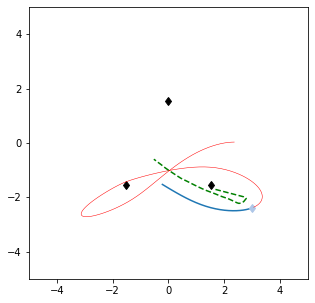


Best Case Predictions : 1



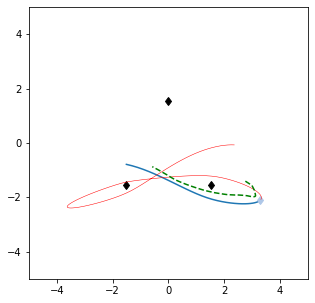


Best Case Predictions : 2



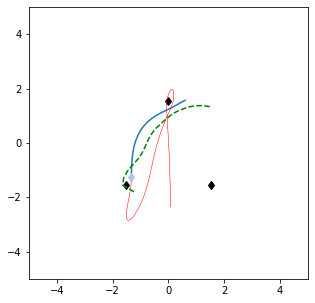


Best Case Predictions : 3



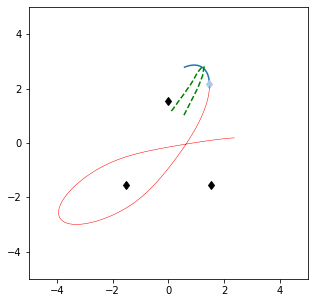


Best Case Predictions : 4



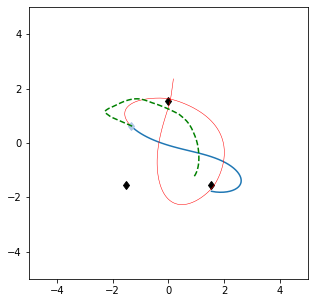


Best Case Predictions : 5



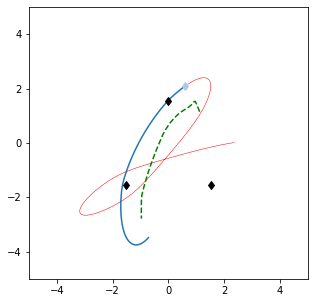


Best Case Predictions : 6



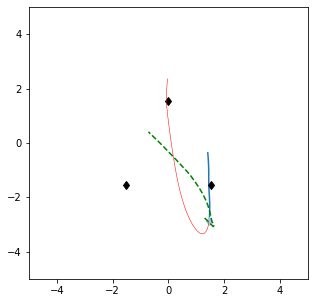


Best Case Predictions : 7



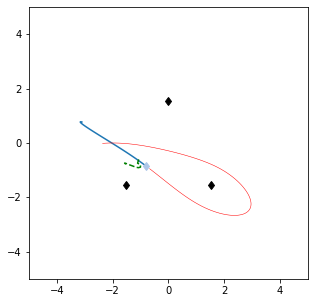


Best Case Predictions : 8



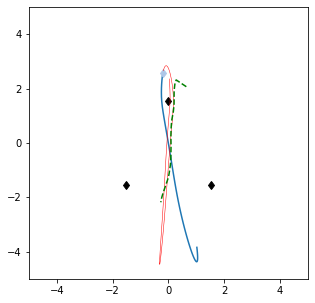


Best Case Predictions : 9



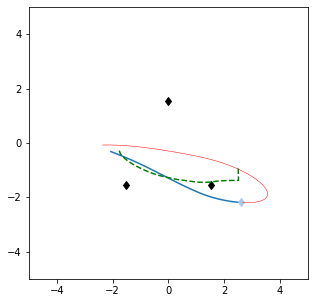

In [60]:
#Plotting the best cases.
for best_idx in range(0,10):
  print(f"\nBest Case Predictions : {best_idx}\n")
  plot_example(x =plot_targets[best_batch][best_idx], x_gt = plot_input[best_batch][best_idx],x_pred = plot_pred[best_batch][best_idx])
  


 Worst Case Predictions : 9



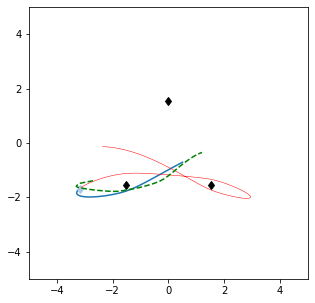


 Worst Case Predictions : 9



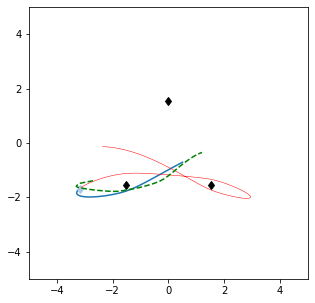


 Worst Case Predictions : 9



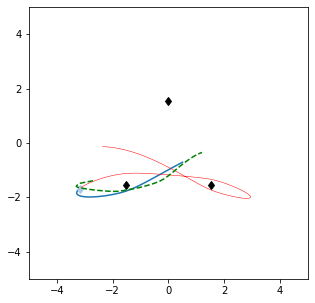


 Worst Case Predictions : 9



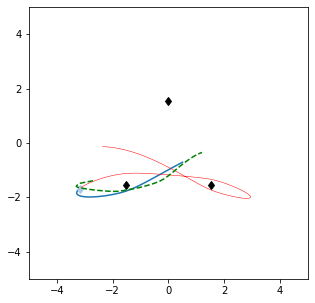


 Worst Case Predictions : 9



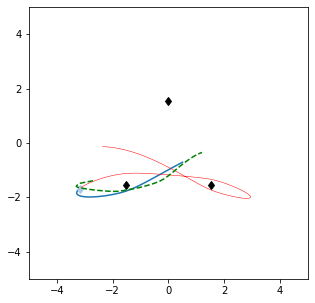


 Worst Case Predictions : 9



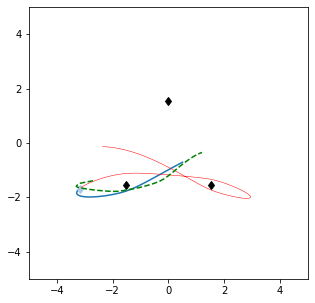


 Worst Case Predictions : 9



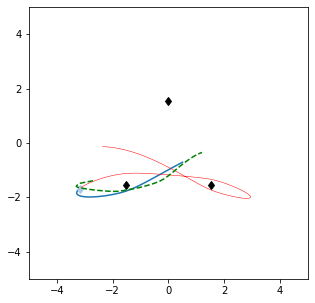


 Worst Case Predictions : 9



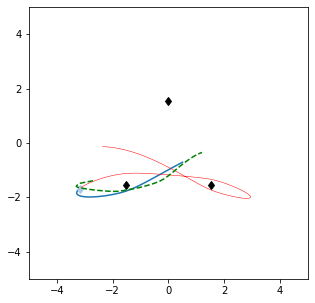


 Worst Case Predictions : 9



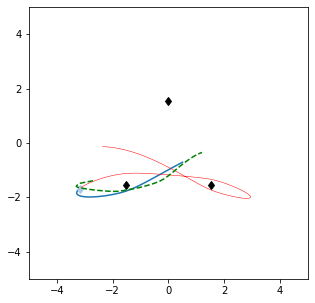


 Worst Case Predictions : 9



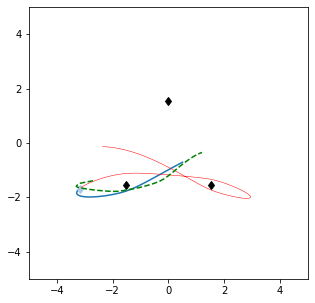

In [61]:
#Plotting the best cases.
for worst_idx in range(0,10):
  print(f"\n Worst Case Predictions : {best_idx}\n")
  plot_example(x =plot_targets[worst_batch][best_idx], x_gt = plot_input[worst_batch][best_idx],x_pred = plot_pred[worst_batch][best_idx])

Experimental Task mentioned in Assignment description : 

"Compare your model to a simple linear
baseline, i.e., extrapolating in the direction between the last 2 timesteps of
the input simulation (xti− xt−Δti)."


In [62]:
def linear_baseline(t1,t2):
    return t1 + (t1 - t2)

In [63]:
#Baseline predictor eval
preds = []
val_running_loss = 0  
for test_data, test_targets in test_loader_2:
    t1 = test_data[:,:,-2:]
    
    t2 = test_data[:,:,-4:-2]
    linear_preds = []
  
    for i in range(20):         
        pred = linear_baseline(t1,t2)
        t2 = t1
        t1 = pred
        linear_preds.append(pred)
    pred = torch.stack(linear_preds,axis=1).squeeze(2).view(len(test_targets),-1)
    #print(pred.shape,test_targets[:,:,:40].view(-1,40).shape)
    
    loss = torch.mean((test_targets[:,:,:40].view(-1,40) - pred)**2)

    print(f" Average loss for linear baseline  : {loss}")
    val_running_loss += loss
print(f"Total average loss: {val_running_loss/len(test_loader_2)}")
    

    

 Average loss for linear baseline  : 1.2266186475753784
 Average loss for linear baseline  : 1.098045825958252
 Average loss for linear baseline  : 0.7036644816398621
 Average loss for linear baseline  : 0.8553469777107239
 Average loss for linear baseline  : 1.410868525505066
 Average loss for linear baseline  : 1.4298721551895142
 Average loss for linear baseline  : 0.501125156879425
 Average loss for linear baseline  : 1.3904789686203003
 Average loss for linear baseline  : 0.6801984310150146
 Average loss for linear baseline  : 0.7997604608535767
Total average loss: 1.0095980167388916
